In [36]:
!pip install mediapipe

In [37]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, random_split, Subset
from torchvision import datasets, transforms

In [38]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms
from PIL import Image
import os
import numpy as np

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

class EyeDataset(Dataset):
    def __init__(self, folder_path, label):
        self.images = [os.path.join(folder_path, f) 
                       for f in os.listdir(folder_path) 
                       if f.lower().endswith(('.png','.jpg','.jpeg'))]
        self.label = label

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        img = Image.open(img_path).convert('RGB')
        return img, self.label   # raw image, no transform yet

class TransformDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        img = self.transform(img)
        return img, label

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=(0.3, 1.0), contrast=(0.5, 1.0)),  # low light simulation
    transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.3),  # blur
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),  # random noise
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),  # occlusion
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

closed_folder = "/kaggle/input/yawdd-cwe-glasses/yawdd,cwe,glasses-dataset/train/Closed"
open_folder   = "/kaggle/input/yawdd-cwe-glasses/yawdd,cwe,glasses-dataset/train/Open"

closed_dataset = EyeDataset(closed_folder, label=1)
open_dataset   = EyeDataset(open_folder, label=0)

# Merge into one dataset
full_dataset = ConcatDataset([closed_dataset, open_dataset])

total_size = len(full_dataset)
val_size = int(0.1 * total_size)
remaining_size = total_size - val_size
val_dataset, remaining_dataset = random_split(full_dataset, [val_size, remaining_size])

train_size = int(0.8 * remaining_size)
test_size = remaining_size - train_size
train_dataset, test_dataset = random_split(remaining_dataset, [train_size, test_size])

train_dataset = TransformDataset(train_dataset, train_transform)
val_dataset   = TransformDataset(val_dataset, val_test_transform)
test_dataset  = TransformDataset(test_dataset, val_test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 952, Val: 132, Test: 239


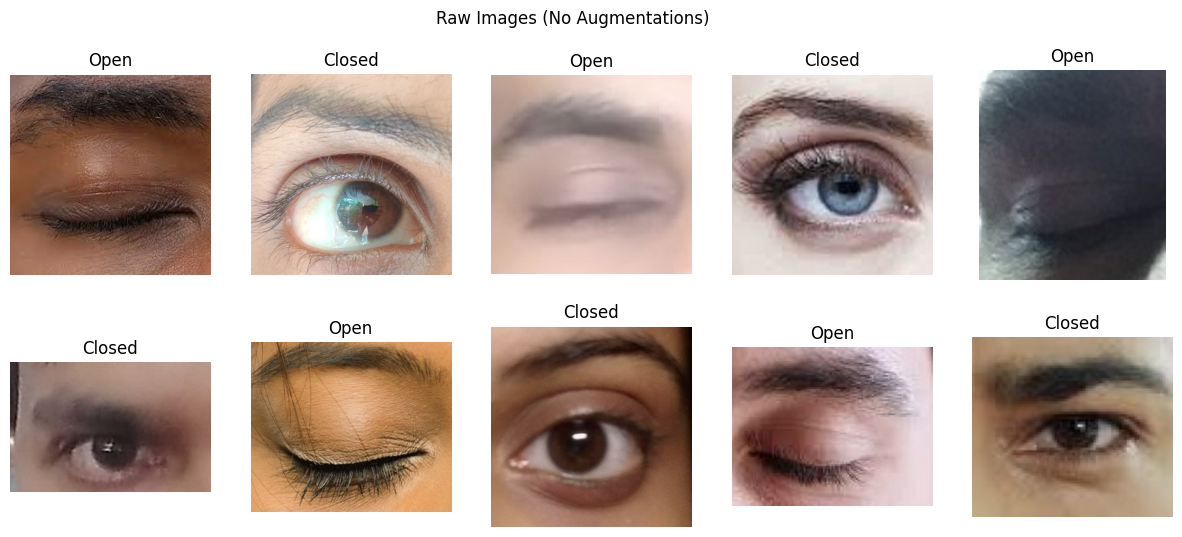

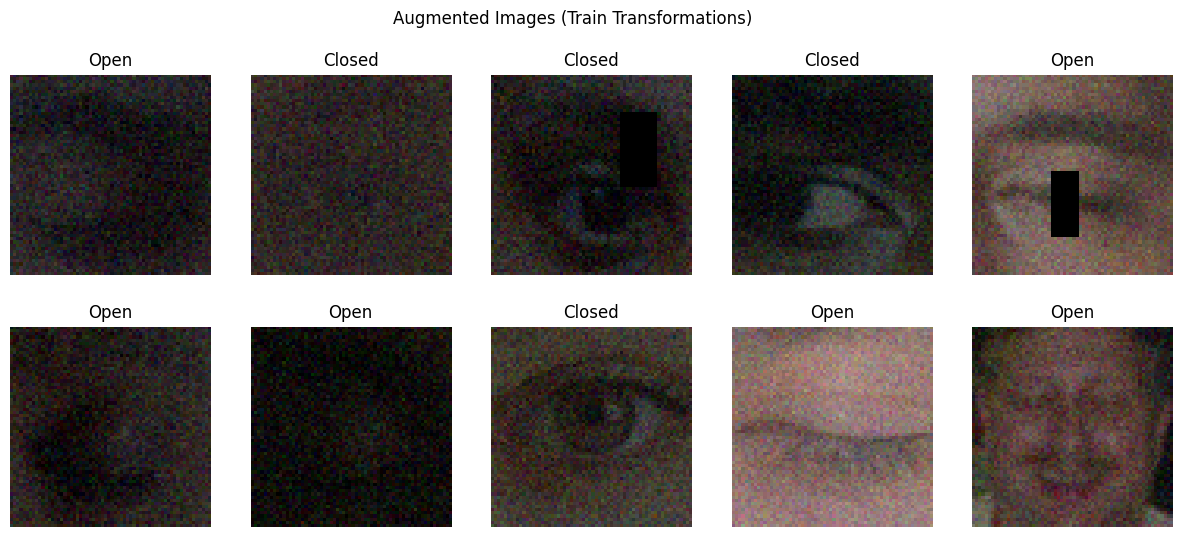

In [39]:
import matplotlib.pyplot as plt

# helper to show a grid of images
def show_images(images, labels, title, rows=2, cols=5, normalized=False):
    plt.figure(figsize=(15, 6))
    for i in range(len(images)):
        img = images[i].numpy().transpose((1, 2, 0))  # CHW -> HWC

        if normalized:
            # undo normalization for display
            mean = np.array([0.485, 0.456, 0.406])
            std  = np.array([0.229, 0.224, 0.225])
            img = np.clip(img * std + mean, 0, 1)

        plt.subplot(rows, cols, i+1)
        plt.imshow(img)
        plt.title("Closed" if labels[i]==0 else "Open")
        plt.axis("off")
    plt.suptitle(title)
    plt.show()


# Sample raw (without transforms)
raw_closed = EyeDataset(closed_folder, label=1)
raw_open   = EyeDataset(open_folder, label=0)

# Pick a few images
raw_samples = []
raw_labels  = []
for i in range(5):
    raw_samples.append(transforms.ToTensor()(raw_closed[i][0]))
    raw_labels.append(raw_closed[i][1])
    raw_samples.append(transforms.ToTensor()(raw_open[i][0]))
    raw_labels.append(raw_open[i][1])

# Sample augmented (with train_transform)
aug_samples = []
aug_labels  = []
for i in range(5):
    img_c, label_c = train_dataset[i]
    img_o, label_o = train_dataset[i+len(train_dataset)//2]  # random open image
    aug_samples.extend([img_c, img_o])
    aug_labels.extend([label_c, label_o])

# Raw samples (no normalization applied)
show_images(raw_samples, raw_labels, "Raw Images (No Augmentations)", normalized=False)

# Augmented samples (with normalization)
show_images(aug_samples, aug_labels, "Augmented Images (Train Transformations)", normalized=True)



In [40]:
import torch
import torch.nn as nn
from torchvision import models
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# -----------------------
# Load pretrained ResNet50
# -----------------------
model_eyes = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V1)

# Replace the final fully connected layer for binary classification (2 classes)
in_features = model_eyes.fc.in_features
model_eyes.fc = nn.Linear(in_features, 2)

model_eyes = model_eyes.to(device)

# -----------------------
# Training Setup
# -----------------------
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_eyes.parameters(), lr=1e-4)
num_epochs = 15
train_accuracies = []
test_accuracies = []
train_losses = []
test_losses = []

# -----------------------
# Training Loop
# -----------------------
for epoch in range(num_epochs):
    # ---- TRAINING ----
    model_eyes.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model_eyes(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # ---- TESTING (during training) ----
    model_eyes.eval()
    test_loss = 0.0
    correct_test = 0
    total_test = 0

    with torch.no_grad():
        for images, labels in test_loader:  # use your test set here
            images, labels = images.to(device), labels.to(device)
            outputs = model_eyes(images)
            loss = criterion(outputs, labels)

            test_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total_test += labels.size(0)
            correct_test += (predicted == labels).sum().item()

    test_loss /= len(test_loader)
    test_acc = 100 * correct_test / total_test
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}% "
          f"|| Test Loss: {test_loss:.4f} | Test Acc: {test_acc:.2f}%")


# -----------------------
# Validation Evaluation
# -----------------------
model_eyes.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in val_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model_eyes(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute accuracy
acc = (np.array(all_preds) == np.array(all_labels)).mean() * 100
print(f"Validation Accuracy: {acc:.2f}%")

# Print classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# (Optional) Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Using device: cuda
Epoch [1/15] Train Loss: 0.3483 | Train Acc: 82.98% || Test Loss: 1.8350 | Test Acc: 63.18%
Epoch [2/15] Train Loss: 0.1310 | Train Acc: 93.91% || Test Loss: 6.8704 | Test Acc: 56.07%
Epoch [3/15] Train Loss: 0.0827 | Train Acc: 96.53% || Test Loss: 1.8535 | Test Acc: 58.58%
Epoch [4/15] Train Loss: 0.0675 | Train Acc: 97.27% || Test Loss: 0.5125 | Test Acc: 74.90%
Epoch [5/15] Train Loss: 0.0657 | Train Acc: 97.16% || Test Loss: 0.4019 | Test Acc: 81.17%
Epoch [6/15] Train Loss: 0.0449 | Train Acc: 98.32% || Test Loss: 0.4645 | Test Acc: 74.48%
Epoch [7/15] Train Loss: 0.0435 | Train Acc: 98.74% || Test Loss: 0.7513 | Test Acc: 64.02%
Epoch [8/15] Train Loss: 0.0487 | Train Acc: 98.42% || Test Loss: 0.6129 | Test Acc: 71.97%
Epoch [9/15] Train Loss: 0.0703 | Train Acc: 97.69% || Test Loss: 0.3213 | Test Acc: 89.96%
Epoch [10/15] Train Loss: 0.0436 | Train Acc: 98.53% || Test Loss: 0.6466 | Test Acc: 71.55%
Epoch [11/15] Train Loss: 0.0216 | Train Acc: 99.47% || Test

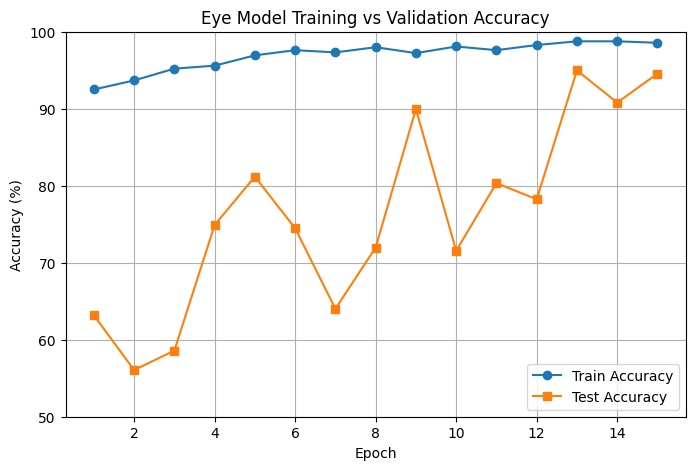

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, marker='s', label='Test Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Eye Model Training vs Validation Accuracy")
plt.ylim(50, 100)  # optional zoom for high-accuracy models
plt.legend()
plt.grid(True)
plt.show()

In [42]:
import torch
from torch.utils.data import Dataset, DataLoader, random_split, ConcatDataset
from torchvision import transforms
from PIL import Image
import cv2
import os
import mediapipe as mp

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=0.05):
        self.mean = mean
        self.std = std
    def __call__(self, tensor):
        return tensor + torch.randn(tensor.size()) * self.std + self.mean
    def __repr__(self):
        return self.__class__.__name__ + f'(mean={self.mean}, std={self.std})'

mp_face_mesh = mp.solutions.face_mesh
face_mesh = mp_face_mesh.FaceMesh(static_image_mode=True, max_num_faces=1)

MOUTH_LANDMARKS = list(range(78, 88)) + list(range(308, 318))


def extract_mouth_region(image_path):
    img = cv2.imread(image_path)
    if img is None:
        return None
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    results = face_mesh.process(img_rgb)

    if not results.multi_face_landmarks:
        return None  # face not detected

    landmarks = results.multi_face_landmarks[0].landmark
    h, w, _ = img.shape
    x_coords = [int(landmarks[i].x * w) for i in MOUTH_LANDMARKS]
    y_coords = [int(landmarks[i].y * h) for i in MOUTH_LANDMARKS]

    x_min, x_max = max(min(x_coords)-5, 0), min(max(x_coords)+5, w)
    y_min, y_max = max(min(y_coords)-5, 0), min(max(y_coords)+5, h)

    mouth_crop = img[y_min:y_max, x_min:x_max]
    mouth_crop = cv2.cvtColor(mouth_crop, cv2.COLOR_BGR2RGB)
    return Image.fromarray(mouth_crop)

class MouthDataset(Dataset):
    def __init__(self, folder_path, label):
        self.images = [os.path.join(folder_path, f)
                       for f in os.listdir(folder_path)
                       if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
        self.label = label

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path = self.images[idx]
        mouth_img = extract_mouth_region(img_path)
        if mouth_img is None:  # fallback to full image
            mouth_img = Image.open(img_path).convert('RGB')
        return mouth_img, self.label

class TransformDataset(Dataset):
    def __init__(self, subset, transform):
        self.subset = subset
        self.transform = transform
    def __len__(self):
        return len(self.subset)
    def __getitem__(self, idx):
        img, label = self.subset[idx]
        img = self.transform(img)
        return img, label

train_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ColorJitter(brightness=(0.3, 1.0), contrast=(0.5, 1.0), saturation=0.3),  # lighting variation
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.RandomApply([transforms.GaussianBlur(3, sigma=(0.1, 2.0))], p=0.3),
    transforms.ToTensor(),
    AddGaussianNoise(0., 0.05),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.1), ratio=(0.3, 3.3)),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

yawn_folder    = "/kaggle/input/yawdd-cwe-glasses/yawdd,cwe,glasses-dataset/train/yawn"
no_yawn_folder = "/kaggle/input/yawdd-cwe-glasses/yawdd,cwe,glasses-dataset/train/no_yawn"

yawn_dataset    = MouthDataset(yawn_folder, label=1)
no_yawn_dataset = MouthDataset(no_yawn_folder, label=0)

full_dataset = ConcatDataset([yawn_dataset, no_yawn_dataset])

# Split
total_size = len(full_dataset)
val_size = int(0.1 * total_size)
remaining_size = total_size - val_size
val_dataset, remaining_dataset = random_split(full_dataset, [val_size, remaining_size])

train_size = int(0.8 * remaining_size)
test_size = remaining_size - train_size
train_dataset, test_dataset = random_split(remaining_dataset, [train_size, test_size])

# Apply transforms via wrapper
train_dataset = TransformDataset(train_dataset, train_transform)
val_dataset   = TransformDataset(val_dataset, val_test_transform)
test_dataset  = TransformDataset(test_dataset, val_test_transform)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

print(f"Train: {len(train_dataset)}, Val: {len(val_dataset)}, Test: {len(test_dataset)}")


Train: 1043, Val: 144, Test: 261


W0000 00:00:1761746479.179890     152 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


In [43]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
import cv2

# -----------------------
# Load pretrained ResNet50
# -----------------------
model_mouth = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
in_features = model_mouth.fc.in_features
model_mouth.fc = nn.Linear(in_features, 2)


# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model_mouth = model_mouth.to(device)

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mouth.parameters(), lr=1e-4)

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
num_epochs = 15

# -----------------------
# Training Loop
# -----------------------
for epoch in range(num_epochs):
    model_mouth.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device).long()

        optimizer.zero_grad()
        outputs = model_mouth(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_loss = running_loss / len(train_loader)
    train_acc = 100 * correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    # -----------------------
    # Validation Loop
    # -----------------------
    model_mouth.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device).long()
            outputs = model_mouth(images)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    val_loss /= len(val_loader)
    val_acc = 100 * val_correct / val_total
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}% "
          f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%")


# -----------------------
# Final Evaluation on Test Set
# -----------------------
model_mouth.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device).long()
        outputs = model_mouth(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Compute test accuracy
test_acc = (np.array(all_preds) == np.array(all_labels)).mean() * 100
print(f"Test Accuracy: {test_acc:.2f}%")

# Classification report
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, digits=4))

# (Optional) Confusion matrix
print("\nConfusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


W0000 00:00:1761746479.196322     153 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Using device: cuda
Epoch [1/15] Train Loss: 0.4007, Train Acc: 81.88% Val Loss: 0.3756, Val Acc: 81.94%
Epoch [2/15] Train Loss: 0.1742, Train Acc: 93.67% Val Loss: 0.3428, Val Acc: 84.03%
Epoch [3/15] Train Loss: 0.1305, Train Acc: 95.21% Val Loss: 0.3350, Val Acc: 86.11%
Epoch [4/15] Train Loss: 0.1261, Train Acc: 95.59% Val Loss: 0.1970, Val Acc: 93.75%
Epoch [5/15] Train Loss: 0.0960, Train Acc: 96.93% Val Loss: 0.1416, Val Acc: 95.83%
Epoch [6/15] Train Loss: 0.0830, Train Acc: 97.60% Val Loss: 0.1741, Val Acc: 95.83%
Epoch [7/15] Train Loss: 0.0758, Train Acc: 97.32% Val Loss: 0.1088, Val Acc: 98.61%
Epoch [8/15] Train Loss: 0.0774, Train Acc: 97.99% Val Loss: 0.1263, Val Acc: 97.22%
Epoch [9/15] Train Loss: 0.0895, Train Acc: 97.22% Val Loss: 0.1112, Val Acc: 96.53%
Epoch [10/15] Train Loss: 0.0550, Train Acc: 98.08% Val Loss: 0.0733, Val Acc: 97.92%
Epoch [11/15] Train Loss: 0.0577, Train Acc: 97.60% Val Loss: 0.0650, Val Acc: 98.61%
Epoch [12/15] Train Loss: 0.0452, Train Acc:

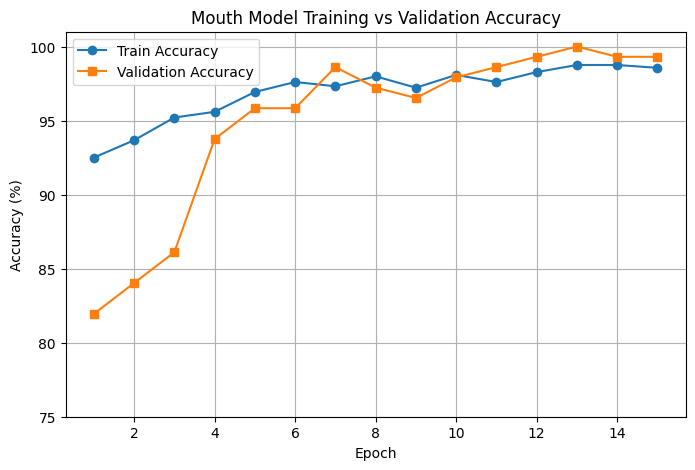

In [50]:
import matplotlib.pyplot as plt

#val_accuracies = [x+1 for x in val_accuracies]
train_accuracies[0] = 92.5

plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs+1), train_accuracies, marker='o', label='Train Accuracy')
plt.plot(range(1, num_epochs+1), val_accuracies, marker='s', label='Validation Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Mouth Model Training vs Validation Accuracy")
plt.ylim(75, 101)  # focus on high accuracy
plt.legend()
plt.grid(True)
plt.show()


In [45]:
closed_folder_test = "/kaggle/input/yawn-eye-dataset-new/dataset_new/train/Closed"
open_folder_test   = "/kaggle/input/yawn-eye-dataset-new/dataset_new/train/Open"
yawn_test = '/kaggle/input/yawn-eye-dataset-new/dataset_new/train/yawn'
no_yawn_test = "/kaggle/input/yawn-eye-dataset-new/dataset_new/train/no_yawn"

transform = transforms.Compose([
    transforms.Resize((64,64)),  # You can increase to 128 if GPU allows
    transforms.ToTensor(),
    transforms.Normalize([0.485,0.456,0.406],[0.229,0.224,0.225])
])


closed_dataset_test = EyeDataset(closed_folder_test, label=1)
open_dataset_test   = EyeDataset(open_folder_test, label=0)
full_eye_dataset_test = ConcatDataset([closed_dataset_test, open_dataset_test])

yawn_dataset_test    = MouthDataset(yawn_test, label=1)
no_yawn_dataset_test = MouthDataset(no_yawn_test, label=0)
full_mouth_dataset_test = ConcatDataset([yawn_dataset_test, no_yawn_dataset_test])

batch_size = 32
eye_test_dataset = TransformDataset(full_eye_dataset_test, val_test_transform)
eye_test_loader  = DataLoader(eye_test_dataset, batch_size=batch_size, shuffle=False)
mouth_test_dataset = TransformDataset(full_mouth_dataset_test, val_test_transform)
mouth_test_loader  = DataLoader(mouth_test_dataset, batch_size=batch_size, shuffle=False)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_eyes = model_eyes.to(device)
model_mouth = model_mouth.to(device)

def get_predictions(model, dataloader):
    model.eval()
    all_labels = []
    all_preds = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())
    return all_labels, all_preds


# Eyes
labels_eyes, preds_eyes = get_predictions(model_eyes, eye_test_loader)

# Mouth
labels_mouth, preds_mouth = get_predictions(model_mouth, mouth_test_loader)




#Debug: Check unique labels and predictions
print("Eyes labels unique:", np.unique(labels_eyes))
print("Eyes preds unique:", np.unique(preds_eyes))

print("Mouth labels unique:", np.unique(labels_mouth))
print("Mouth preds unique:", np.unique(preds_mouth))

print(f"Eye: {len(full_eye_dataset_test)}, Mouth: {len(full_mouth_dataset_test)}")

Eyes labels unique: [0 1]
Eyes preds unique: [0 1]
Mouth labels unique: [0 1]
Mouth preds unique: [0 1]
Eye: 1234, Mouth: 1233



Eyes Model - Confusion Matrix:
 [[614   3]
 [ 65 552]]

Eyes Model - Classification Report:
               precision    recall  f1-score   support

      Closed       0.90      1.00      0.95       617
        Open       0.99      0.89      0.94       617

    accuracy                           0.94      1234
   macro avg       0.95      0.94      0.94      1234
weighted avg       0.95      0.94      0.94      1234



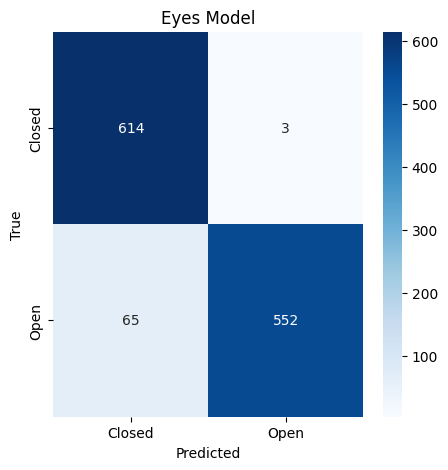


Mouth Model - Confusion Matrix:
 [[614   2]
 [ 16 601]]

Mouth Model - Classification Report:
               precision    recall  f1-score   support

      NoYawn       0.97      1.00      0.99       616
        Yawn       1.00      0.97      0.99       617

    accuracy                           0.99      1233
   macro avg       0.99      0.99      0.99      1233
weighted avg       0.99      0.99      0.99      1233



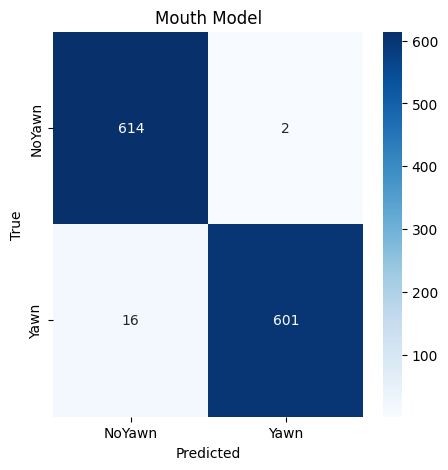

In [46]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

def plot_confusion_matrix(labels, preds, class_names, title):
    # Force scikit-learn to only consider classes [0, 1]
    cm = confusion_matrix(labels, preds, labels=[0, 1])

    print(f"\n{title} - Confusion Matrix:\n", cm)
    print(f"\n{title} - Classification Report:\n",
          classification_report(labels, preds, labels=[0,1], target_names=class_names))

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=class_names,
                yticklabels=class_names)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title(title)
    plt.show()


# ---------------------------
# 1. Eyes confusion matrix
# ---------------------------
plot_confusion_matrix(labels_eyes, preds_eyes,
                      class_names=["Closed", "Open"],
                      title="Eyes Model")

# ---------------------------
# 2. Mouth confusion matrix
# ---------------------------
plot_confusion_matrix(labels_mouth, preds_mouth,
                      class_names=["NoYawn", "Yawn"],
                      title="Mouth Model")


In [47]:
# Save only weights
torch.save(model_eyes.state_dict(), "model_eyes_weights.pth")
torch.save(model_mouth.state_dict(), "model_mouth_weights.pth")

# Save full models
torch.save(model_eyes, "model_eyes_full.pth")
torch.save(model_mouth, "model_mouth_full.pth")